In the previous notebook, I utilized Azure AutoML for an object detection task. This platform automatically runs multiple experiments, testing various models and hyperparameters. After reviewing the experiment history, I decided to run several experiments using the same models and hyperparameters for comparison. Specifically, I want to compare Faster R-CNN ResNet-50-FPN model, YOLOv5 model without hyperparameter tuning, and YOLOv5 model with the best hyperparameter obtained from the previous AutoML experiment. I will use the same road sign detection dataset.

### Experiment 1: Faster R-CNN ResNet-50-FPN

#### Faster R-CNN under two minutes
Faster R-CNN is an object detection system proposed in [this paper](https://arxiv.org/abs/1506.01497) that consists of two main modules: a Region Proposal Network (RPN) and a Fast R-CNN detector. The RPN is responsible for proposing regions in an image, while the Fast R-CNN detector uses these proposed regions for object detection. By sharing convolutional layers between the RPN and Fast R-CNN, the system can efficiently generate region proposals and improving object detection accuracy.

The proposed method works by integrating RPN with Fast R-CNN detector into a single unified network for object detection. The RPN module serves as the ‘attention’ mechanism of the unified network, guiding the Fast R-CNN module on where to focus for object detection. The RPN is a fully convolutional network that shares convolutional layers with the detection network. It will simultaneously predicts region bounds and objectness scores at each position in the image. The RPN will outputs a set of rectangular object proposals, each with an objectness score. The Fast R-CNN detector then uses the proposed regions from the RPN for object detection. By sharing convolutional layers with the RPN, the Fast R-CNN can focus on detecting object within the proposed regions.

#### And, what is Faster R-CNN ResNet-50-FPN?
From [this PyTorch docs](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html), Faster R-CNN ResNet-50-FPN is Faster R-CNN model with ResNet-50-FPN as the backbone.

#### References
[Faster R-CNN ResNet-50-FPN PyTorch docs](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)\
[Faster R-CNN Paper](https://arxiv.org/abs/1506.01497)\
[A Simple Pipeline to Train PyTorch Faster R-CNN Object Detection Model](https://debuggercafe.com/a-simple-pipeline-to-train-pytorch-faster-rcnn-object-detection-model/)\
[Custom Object Detection using PyTorch Faster R-CNN](https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/)\
[torchmetrics Precision](https://lightning.ai/docs/torchmetrics/stable/classification/precision.html)\
[torchmetrics Recall](https://lightning.ai/docs/torchmetrics/stable/classification/recall.html#id3)\
[torchmetrics Mean Average Precision](https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html#torchmetrics.detection.mean_ap.MeanAveragePrecision.params.average)

#### Implementation
I will refer to [this post](https://debuggercafe.com/a-simple-pipeline-to-train-pytorch-faster-rcnn-object-detection-model/) and [this post](https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/) for running object detection with Faster R-CNN ResNet-50-FPN. Both posts split the entire training pipeline into several files,. However, for the sake of simplicity, I put all these steps into a single notebook.

The code requires access to both the training and validation directories. In the past notebook, this wasn’t implemented, so I need to split the dataset here.

In [1]:
import zipfile, os

zip_file = '../datasets/road-sign-detection.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('../datasets/road-sign-detection-v2')
zip_ref.close()

In [2]:
import splitfolders

splitfolders.ratio("../datasets/road-sign-detection-v2", 
                   output="../datasets/road-sign-detection-v2/split-data",
                   ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 1754 files [00:30, 58.33 files/s]


In [6]:
os.listdir('../datasets/road-sign-detection-v2/split-data')

['test', 'train', 'val']

Initialize the training configurations. The descriptions of each variable are provided in the comments.

In [1]:
import torch

# Batch size to use for training
BATCH_SIZE = 8
# Dimensions the images to resize to
RESIZE_TO = 512
# Number of epochs to train for
NUM_EPOCHS = 20
# Number of workers or sub-processes to use for data loading
NUM_WORKERS = 0

# Computation device to use for training
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Path to the training and validation images and xml files
TRAIN_DIR = "../datasets/road-sign-detection-v2/split-data/train"
VAL_DIR = "../datasets/road-sign-detection-v2/split-data/val"

# Classes and number of classes. The class at index 0 is always the __background__ class.
# This is because PyTorch Faster R-CNN always expect this additional class along
# with the classes of dataset.
CLASSES = [
    '__background__', 'trafficlight', 'stop', 'speedlimit', 'crosswalk'
]
NUM_CLASSES = len(CLASSES)

# Controls whether we want to visualize the data loader images just before training
VISUALIZE_TRANSFORMED_IMAGES = True

# Path to the directory to store trained models
OUT_DIR = '../models/road-sign-detection-v2/faster-rcnn'

Next, define the utility classes. The Averager class keeps track of the training and validation loss values and helps to get the average loss after each epoch.

In [2]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt

from albumentations.pytorch import ToTensorV2

plt.style.use('ggplot')

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
    
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
        
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

The SaveBestModel class is responsible for saving the best model after each epoch. The instance of this class is called with the current epoch’s validation loss as an argument. If this loss is lower than the previous best loss, then the current model is saved.

In [3]:
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
    
    def __call__(self, current_valid_loss, epoch, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, '../models/road-sign-detection-v2/faster-rcnn/best_model.pth')

Next, the helper functions. The collate_fn() function will handle the data loading as different images may have different number of objects, handle varying size tensors, and handle the images and bounding boxes of varying sizes. The get_train_transform() and get_valid_transform() functions definining the data augmentations for the images. Albumentations library will also handle the orientation of the corresponding bounding boxes when applying these augmentations.

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0)
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def get_val_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

The show_transformed_image() function shows the transformed images from the train loader. This will helps to check that the augmented images and the bounding boxes are correct. The save_model() function saves the trained model after each epoch and after training ends. The save_loss_plot() function saves the training and validation loss graphs and called after each epoch.

In [5]:
def show_transformed_image(train_loader):
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
                cv2.putText(sample, CLASSES[labels[box_num]], (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
                
            sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)
            plt.imshow(sample)
            plt.show()

def save_model(epoch, model, optimizer):
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, '../models/road-sign-detection-v2/faster-rcnn/last_model.pth')
    
def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('SAVING PLOTS COMPLETE')
    
    plt.close('all')

Prepare the PASCAL VOC dataset by extracting information from the XML annotation file. The descriptions of each process are provided in the comments.

In [6]:
import glob

from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader

class DatasetPrep(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        # Training or validation transforms. The image augmentations
        # we want to carry out
        self.transforms = transforms
        # Path to the training or validation directory
        self.dir_path = dir_path
        # Dimensions to resize the images to. Also change the respective 
        # bounding box coordinate values
        self.height = height
        self.width = width
        # List containing all the class names
        self.classes = classes
        
        # List contains all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/images/*.png")
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
        
    def __getitem__(self, idx):
        # Get the current image path
        image_name = self.all_images[idx]
        image_path = f"{self.dir_path}/images/{image_name}"
        
        # Read the image
        image = cv2.imread(image_path)
        # Convert the color format from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # Resize to the required height and width
        image_resized = cv2.resize(image, (self.width, self.height))
        # Scale the image pixels
        image_resized /= 255.0
        
        # Read the corresponding XML file for the image
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, 'annotations', annot_filename)
        
        # Lists to store the bounding box coordinates and labels for the current image
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # Get the height and the width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # Parse through the XML file
        for member in root.findall('object'):
            # Append the class name to labels
            labels.append(self.classes.index(member.find('name').text))
            
            # Extract the bounding box coordinates
            # xmin -> x left corner
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax -> x right corner
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin -> y left corner
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax -> y right corner
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # Resize those bounding boxes to the desired height and width
            xmin_final = (xmin/image_width) * self.width
            xmax_final = (xmax/image_width) * self.width
            ymin_final = (ymin/image_height) * self.height
            ymax_final = (ymax/image_height) * self.height
            
            # Append the resized bounding boxes to the boxes list
            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
            
        # Convert the boxes and labels list to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Calculate the area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # None of our data is labeled as iscrowd
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        
        # Dictionary where we store all of the informations
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        image_id = torch.tensor([idx])
        target['image_id'] = image_id
        
        # Apply the transforms to the image and return the resized image 
        # and the target dictionary
        if self.transforms:
            sample = self.transforms(image=image_resized, bboxes=target['boxes'], labels=labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target
    
    def __len__(self):
        return len(self.all_images)

The next step is to create training and validation dataset and data loaders.

In [7]:
def create_train_dataset():
    train_dataset = DatasetPrep(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
    
    return train_dataset

def create_val_dataset():
    val_dataset = DatasetPrep(VAL_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_val_transform())
    
    return val_dataset

def create_train_loader(train_dataset, num_workers=0):
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
    
    return train_loader

def create_val_loader(val_dataset, num_workers=0):
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
    
    return val_loader

Check whether all the data preparation is working correctly or not.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of training images: 701


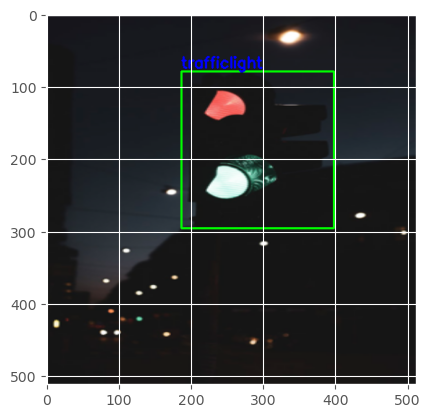

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


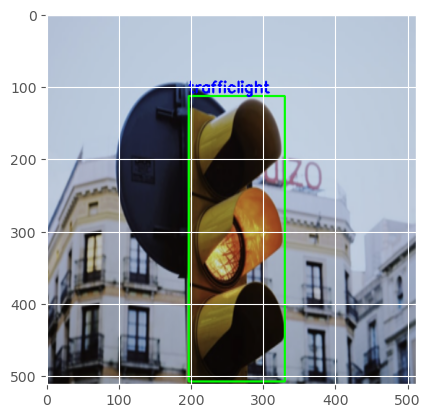

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


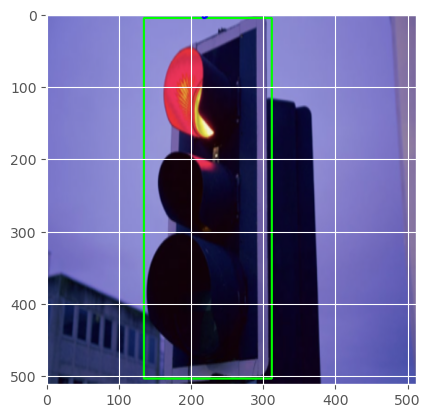

In [8]:
import os

test_check_dataset = DatasetPrep(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES)
print(f"Number of training images: {len(test_check_dataset)}")

# Visualize a single sample
def visualize_sample(image, target):
    for box_num in range(len(target['boxes'])):
        box = target['boxes'][box_num]
        label = CLASSES[target['labels'][box_num]]
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
        cv2.putText(image, label, (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
    plt.imshow(image)
    plt.show()
    
NUM_SAMPLES_TO_VISUALIZE = 3
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = test_check_dataset[i]
    visualize_sample(image, target)

Prepare Faster R-CNN model with ResNet-50-FPN backbone. PyTorch already provides the pre-trained model so we just need to load the model, get the number of input features, and define a new head for the detector with the correct number of classes according to the dataset.

In [9]:
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # Load the model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weigths='DEFAULT')
    # Get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Change the head of Faster R-CNN detector according to 
    # the in_features and the number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

Next, the training function to carry out the object detection forward and backward pass. The train() function accepts the training data loader and the model. The descriptions of each process are provided in the comments.

In [10]:
from tqdm.auto import tqdm

import time

def train(train_data_loader, model):
    print('Training')
    # Lists that keep on storing the number of training iterations and 
    # the training loss for each iteration until the end of training
    global train_itr
    global train_loss_list
    
    # Define progress bar
    # The loss values for each batch will keep on updating
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    # Iterate over the batches
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        # Extract the images and targets
        images, targets = data
        
        # Load them onto the computation device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        
        # Sum the losses
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        # Append the current iteration's loss value to train_loss_list
        train_loss_list.append(loss_value)
        
        # Send the current loss value to train_loss_hist of the Averager class
        train_loss_hist.send(loss_value)
        
        # Backpropagate the gradients and update parameters
        losses.backward()
        optimizer.step()
        
        train_itr += 1
        
        # Displaying the updated loss
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        
    # Returns a list containing the training loss values for all the completed
    # iterations
    return train_loss_list

The validation function is very similar to the training function, except there’s no backpropagation and no parameter update. The function also returns a similar list containing the loss values for all the completed iterations.

In [11]:
def validate(val_data_loader, model):
    print('Validation')
    global val_itr
    global val_loss_list
    
    prog_bar = tqdm(val_data_loader, total=len(val_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        
        val_loss_hist.send(loss_value)
        
        val_itr += 1
        
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        
    return val_loss_list

After setting up all of these functions, the next step is to call the functions to start the training process.

In [12]:
train_dataset = create_train_dataset()
val_dataset = create_val_dataset()

train_loader = create_train_loader(train_dataset, NUM_WORKERS)
val_loader = create_val_loader(val_dataset, NUM_WORKERS)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 701
Number of validation samples: 87


Initialize the model, move to the computation device, get the model parameters, and define the optimizer. Here we use the SGD optimizer with a learning rate of 0.001 and momentum of 0.9.

In [13]:
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

Initialize the Averager class and create lists to store the training and validation loss values. These lists will store the loss values from all iterations.

In [14]:
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

Initialize the name for saving the trained model, set up the transformed images display, and initialize the SaveBestModel class. I encountered an error when trying to show the transformed images, specifically, the DataLoader worker failed. To resolve this, I set the NUM_WORKERS to 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


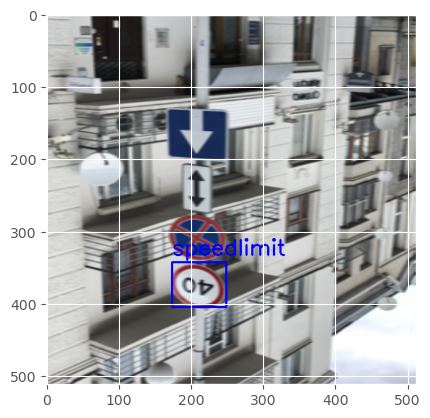

In [15]:
MODEL_NAME = 'faster-rcnn-resnet-50-fpn'

if VISUALIZE_TRANSFORMED_IMAGES:
    show_transformed_image(train_loader)

save_best_model = SaveBestModel()

I have added an early stopping function to the training process. This function will halt the training if the validation loss does not improve for 5 consecutive epochs.

In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Start the training epoch iteration. Here we call the train() function to train the model on the training data, and the validate() function to evaluate the model on the validation data. We save the model that performs best on the validation data, the model from every epoch, and the loss graphs.

In [17]:
early_stopper = EarlyStopper(patience=5, min_delta=10)

for epoch in range(NUM_EPOCHS):
    print(f"\n EPOCH {epoch+1} OF {NUM_EPOCHS}")
    
    # Reset the training and validation loss histories
    train_loss_hist.reset()
    val_loss_hist.reset()
    
    # Start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(val_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Time elapsed for epoch {epoch+1}: {((end - start) / 60):.3f}")
    
    # Save the best model if we have the least loss in the current epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    
    # Save the current epoch model
    save_model(epoch, model, optimizer)
    
    # Save loss plot
    save_loss_plot(OUT_DIR, train_loss, val_loss)

    # Early stop
    if early_stopper.early_stop(val_loss_hist.value):
        break
    
    # Sleep for 5 seconds after each epoch
    time.sleep(5)


 EPOCH 1 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #1 train loss: 0.553
Epoch #1 validation loss: 0.326
Time elapsed for epoch 1: 88.775

Best validation loss: 0.32574356956915423

Saving best model for epoch: 1

SAVING PLOTS COMPLETE

 EPOCH 2 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #2 train loss: 0.293
Epoch #2 validation loss: 0.316
Time elapsed for epoch 2: 70.959

Best validation loss: 0.3161685046824542

Saving best model for epoch: 2

SAVING PLOTS COMPLETE

 EPOCH 3 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #3 train loss: 0.283
Epoch #3 validation loss: 0.289
Time elapsed for epoch 3: 70.556

Best validation loss: 0.2890206358649514

Saving best model for epoch: 3

SAVING PLOTS COMPLETE

 EPOCH 4 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #4 train loss: 0.243
Epoch #4 validation loss: 0.244
Time elapsed for epoch 4: 76.253

Best validation loss: 0.24411831118843771

Saving best model for epoch: 4

SAVING PLOTS COMPLETE

 EPOCH 5 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #5 train loss: 0.216
Epoch #5 validation loss: 0.208
Time elapsed for epoch 5: 77.297

Best validation loss: 0.20803459936922247

Saving best model for epoch: 5

SAVING PLOTS COMPLETE

 EPOCH 6 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #6 train loss: 0.204
Epoch #6 validation loss: 0.211
Time elapsed for epoch 6: 70.382
SAVING PLOTS COMPLETE

 EPOCH 7 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #7 train loss: 0.191
Epoch #7 validation loss: 0.201
Time elapsed for epoch 7: 71.020

Best validation loss: 0.20096922462636774

Saving best model for epoch: 7

SAVING PLOTS COMPLETE

 EPOCH 8 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #8 train loss: 0.185
Epoch #8 validation loss: 0.204
Time elapsed for epoch 8: 71.993
SAVING PLOTS COMPLETE

 EPOCH 9 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #9 train loss: 0.180
Epoch #9 validation loss: 0.189
Time elapsed for epoch 9: 81.976

Best validation loss: 0.18854863128878854

Saving best model for epoch: 9

SAVING PLOTS COMPLETE

 EPOCH 10 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #10 train loss: 0.174
Epoch #10 validation loss: 0.191
Time elapsed for epoch 10: 70.765
SAVING PLOTS COMPLETE

 EPOCH 11 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #11 train loss: 0.167
Epoch #11 validation loss: 0.179
Time elapsed for epoch 11: 70.628

Best validation loss: 0.17933441495353525

Saving best model for epoch: 11

SAVING PLOTS COMPLETE

 EPOCH 12 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #12 train loss: 0.166
Epoch #12 validation loss: 0.171
Time elapsed for epoch 12: 70.776

Best validation loss: 0.17131017554890027

Saving best model for epoch: 12

SAVING PLOTS COMPLETE

 EPOCH 13 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #13 train loss: 0.166
Epoch #13 validation loss: 0.175
Time elapsed for epoch 13: 70.266
SAVING PLOTS COMPLETE

 EPOCH 14 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #14 train loss: 0.155
Epoch #14 validation loss: 0.161
Time elapsed for epoch 14: 70.447

Best validation loss: 0.16106799922206186

Saving best model for epoch: 14

SAVING PLOTS COMPLETE

 EPOCH 15 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #15 train loss: 0.155
Epoch #15 validation loss: 0.168
Time elapsed for epoch 15: 70.255
SAVING PLOTS COMPLETE

 EPOCH 16 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #16 train loss: 0.149
Epoch #16 validation loss: 0.169
Time elapsed for epoch 16: 70.112
SAVING PLOTS COMPLETE

 EPOCH 17 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #17 train loss: 0.148
Epoch #17 validation loss: 0.167
Time elapsed for epoch 17: 72.708
SAVING PLOTS COMPLETE

 EPOCH 18 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #18 train loss: 0.143
Epoch #18 validation loss: 0.157
Time elapsed for epoch 18: 73.882

Best validation loss: 0.15704293210398068

Saving best model for epoch: 18

SAVING PLOTS COMPLETE

 EPOCH 19 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #19 train loss: 0.141
Epoch #19 validation loss: 0.145
Time elapsed for epoch 19: 72.395

Best validation loss: 0.14484242282130502

Saving best model for epoch: 19

SAVING PLOTS COMPLETE

 EPOCH 20 OF 20
Training


  0%|          | 0/88 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch #20 train loss: 0.138
Epoch #20 validation loss: 0.153
Time elapsed for epoch 20: 72.855
SAVING PLOTS COMPLETE


Below are the training and validation loss graphs.

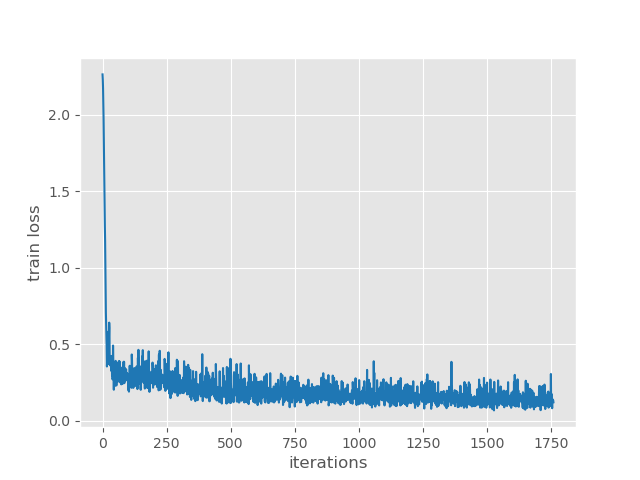

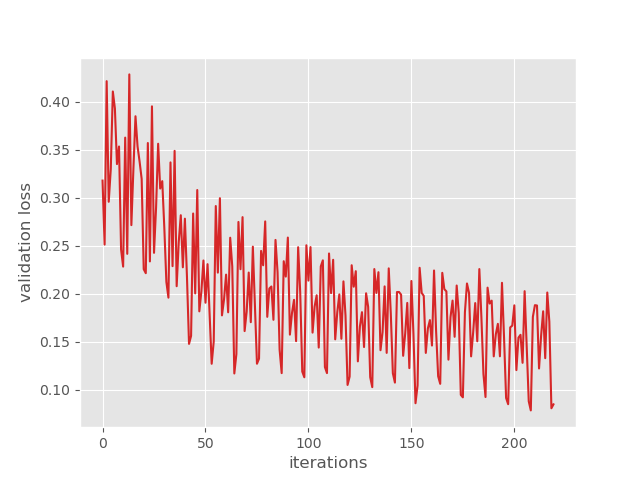

In [19]:
from IPython.display import Image

PLOT_DIR = "../models/road-sign-detection-v2/faster-rcnn"
plot_images = glob.glob(f"{PLOT_DIR}/*.png")

for i in range(len(plot_images)):
    display(Image(filename=plot_images[i]))

From the training loss graph, we can see that the model’s loss decreased sharply at the beginning and then the loss continues to decrease gradually, means the model is still learning, but the improvements are not as higher as the initial iteration. From the validation loss graph, the fluctuations in the graph could be due to the model’s performance on the validation set. There’s a slight downward trend in the validation loss, means the improvements are not high.

After the training process is completed, evaluate the model and its weights. The evaluation metrics that will be computed include precision, recall, and mean average precision. We have set aside test data that wasn’t used during the training. These data will be used to perform the evaluation.

In [10]:
# Load best weight
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('../models/road-sign-detection-v2/faster-rcnn/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [11]:
TEST_DIR = "../datasets/road-sign-detection-v2/split-data/test"

# Make use of validation functions
def create_test_dataset():
    test_dataset = DatasetPrep(TEST_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_val_transform())
    
    return test_dataset

def create_test_loader(test_dataset, num_workers=0):
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
    
    return test_loader

In [12]:
test_dataset = create_test_dataset()
test_loader = create_test_loader(test_dataset, NUM_WORKERS)
print(f"Number of test samples: {len(test_dataset)}")

Number of test samples: 89


In [13]:
from torchmetrics import Precision, Recall
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint
from tqdm import tqdm

import time
import logging

detection_threshold = .5

def evaluate(model, data_loader, device, classes=None):
    precision_metric = Precision(task="multiclass", num_classes=NUM_CLASSES)
    recall_metric = Recall(task="multiclass", num_classes=NUM_CLASSES)
    map_metric = MeanAveragePrecision()
    
    cpu_device = torch.device("cpu")
    model.eval()
    logger = logging.getLogger(__name__)
    header = "Test:"
    
    target = []
    preds = []
    preds_tensor = []
    counter = 0
    for images, targets in tqdm(data_loader, total=len(data_loader)):
        counter += 1
        images = list(img.to(device) for img in images)

        model_time = time.time()
        with torch.no_grad():
            outputs = model(images)

        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()

            get_num_labels = len(true_dict['labels'])
            
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            
            preds.append(preds_dict)
            target.append(true_dict)

            if len(outputs[0]['boxes']) != 0:
                boxes = outputs[0]['boxes'].data.numpy()
                scores = outputs[0]['scores'].data.numpy()
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()
                pred_classes_num = [i for i in outputs[0]['labels'].cpu().numpy()]

                class_num = []
                if len(boxes) == 0:
                    class_num.extend([0] * get_num_labels)
                else:
                    for j, box in enumerate(draw_boxes):
                        class_num.append(pred_classes_num[j])
                
                if len(class_num) < get_num_labels:
                    class_num.extend([0] * (get_num_labels - len(class_num)))
                elif len(class_num) > get_num_labels:
                    class_num = class_num[:get_num_labels]
            
                preds_tensor.append(torch.tensor(class_num))
        
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    
    map_metric.update(preds, target)
    
    preds_tensor =  torch.cat(preds_tensor)

    target_label = [t['labels'] for t in target]
    target_tensor = torch.cat(target_label)

    precision_metric.update(preds_tensor, target_tensor)
    recall_metric.update(preds_tensor, target_tensor)
    
    precision_summary = precision_metric.compute()
    recall_summary = recall_metric.compute()
    map_summary = map_metric.compute()
    
    return (f"Precision: {precision_summary}, Recall: {recall_summary}, MAP: {map_summary}")

In [14]:
eval = evaluate(model, test_loader, device=DEVICE, classes=CLASSES)
pprint(eval)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:28<00:00, 17.35s/it]


("Precision: 0.5285714268684387, Recall: 0.5285714268684387, MAP: {'map': "
 "tensor(0.5107), 'map_50': tensor(0.7878), 'map_75': tensor(0.5676), "
 "'map_small': tensor(0.2282), 'map_medium': tensor(0.5990), 'map_large': "
 "tensor(0.6420), 'mar_1': tensor(0.5191), 'mar_10': tensor(0.5901), "
 "'mar_100': tensor(0.5969), 'mar_small': tensor(0.3021), 'mar_medium': "
 "tensor(0.6586), 'mar_large': tensor(0.7038), 'map_per_class': tensor(-1.), "
 "'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4], "
 'dtype=torch.int32)}')


The precision and recall functions require the predicted labels and true labels to have the same shape. Without any adjustments, I encountered some errors. Therefore, I made the following adjustments: if there are no predicted items, the predicted label will be set to 0 for all the expected number of true labels. If the number of predicted labels is less than the number of true labels, the remaining labels will be set to 0. If the number of predicted labels is larger than the number of true labels, the excess labels are removed.

Precision measures the ability of the classifier to avoid labelling negative samples as positive. Recall measures the ability of the classifier to find all positive samples. Mean average precision measures the average value of the average precision across all the classes. It appears that the model is moderately successful in predicting positive samples, identifying all positive samples, and has a moderate average precision across all classes.

Next, I carried out inferences on several images. The images I chose for prediction are shown below.

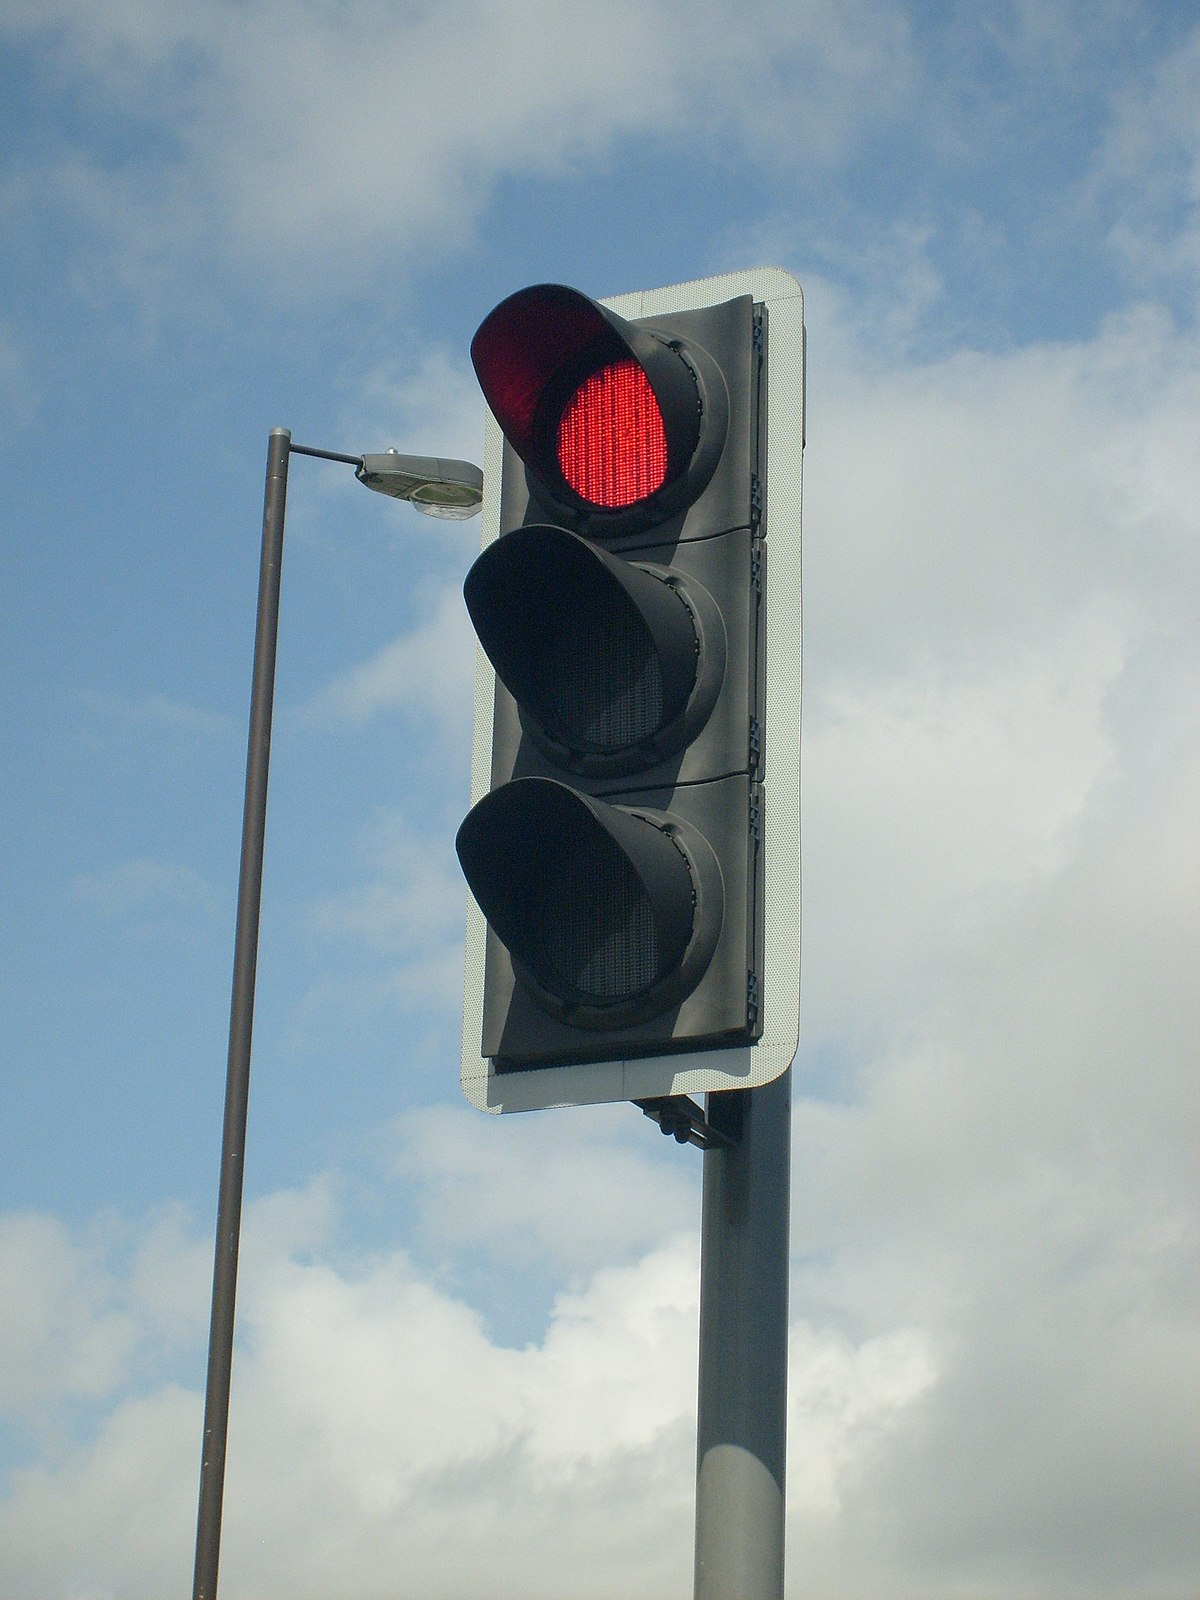

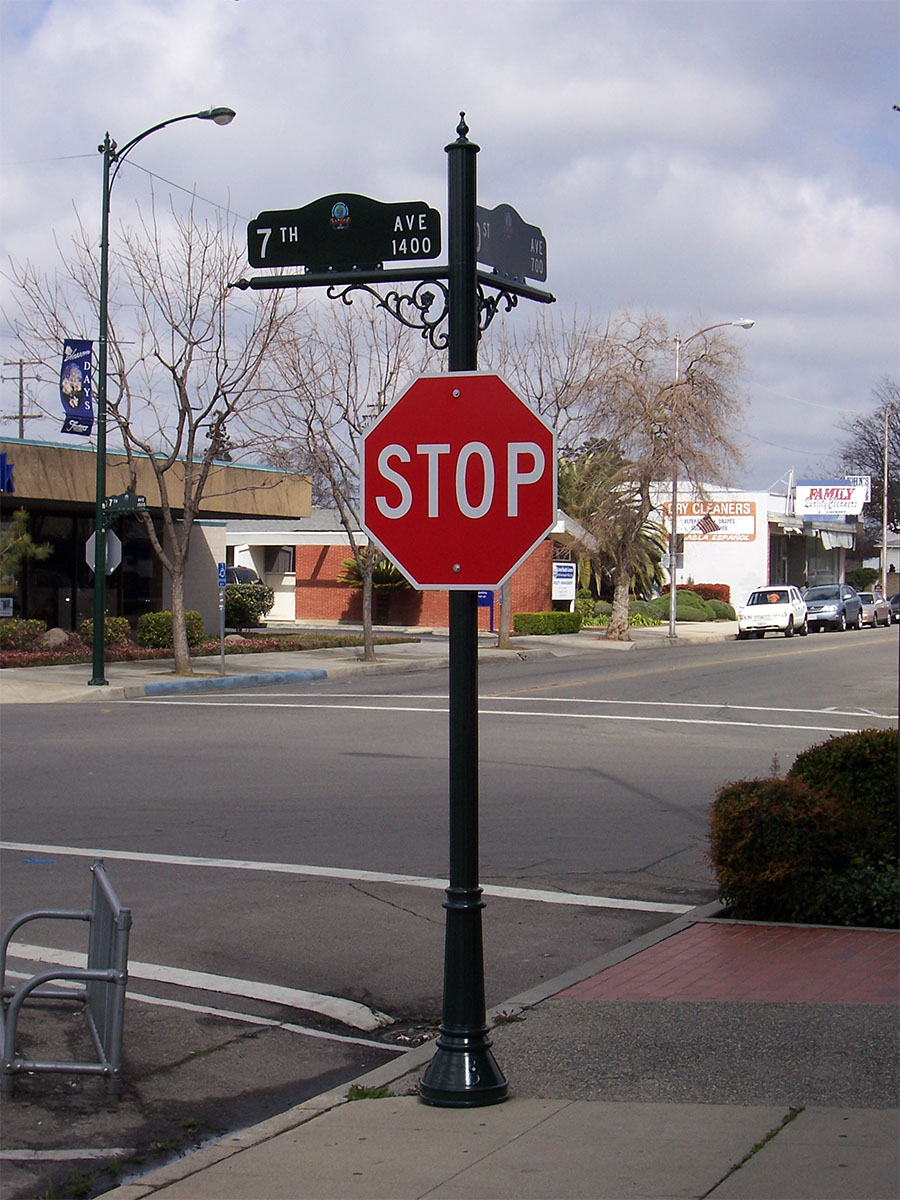

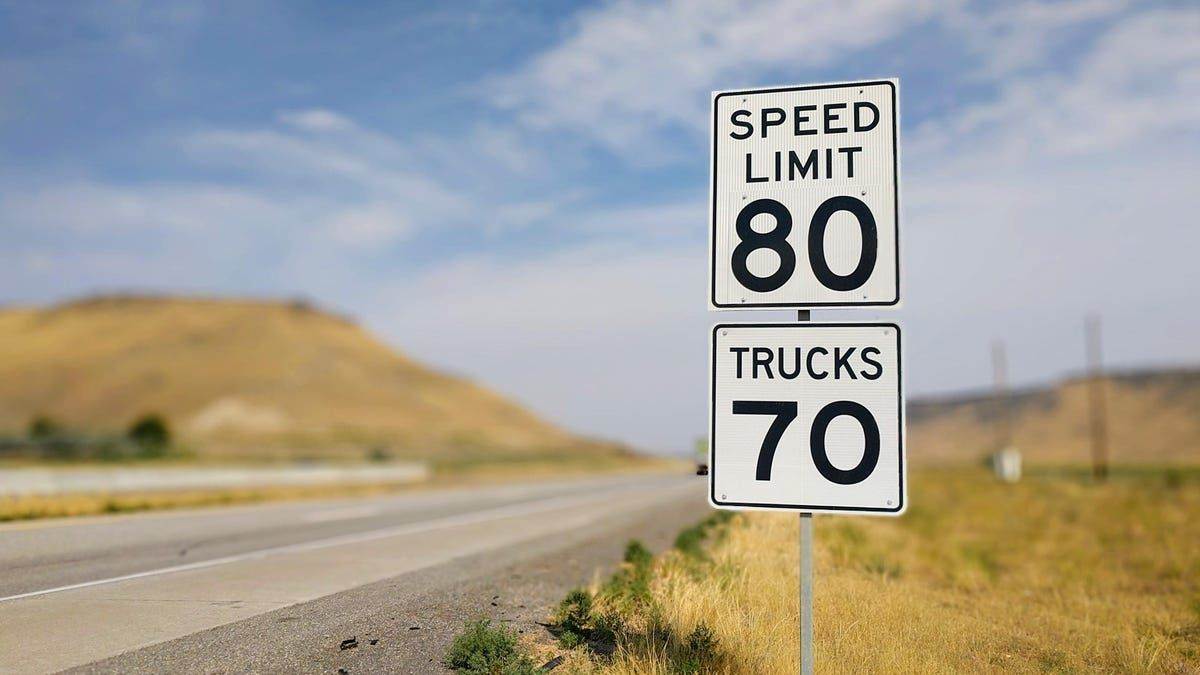

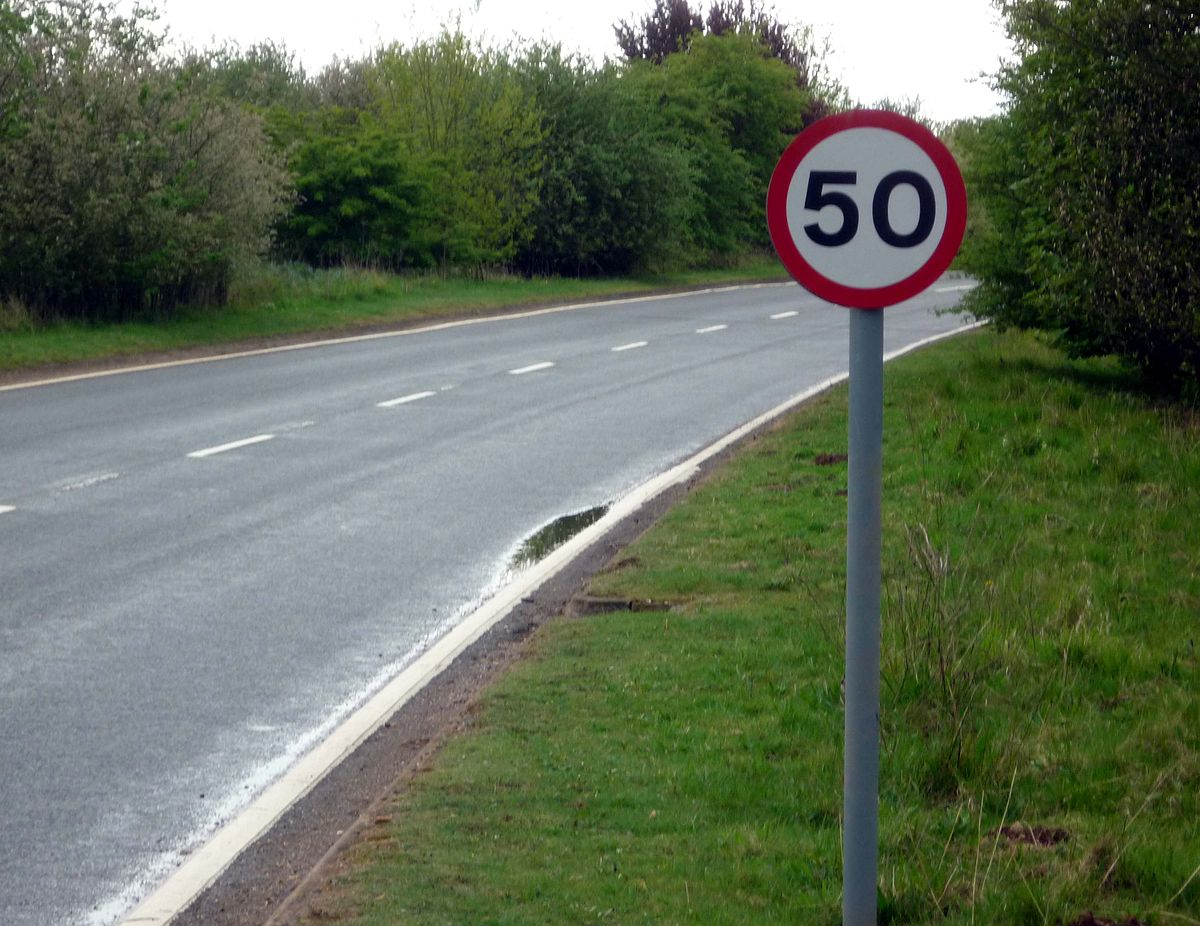

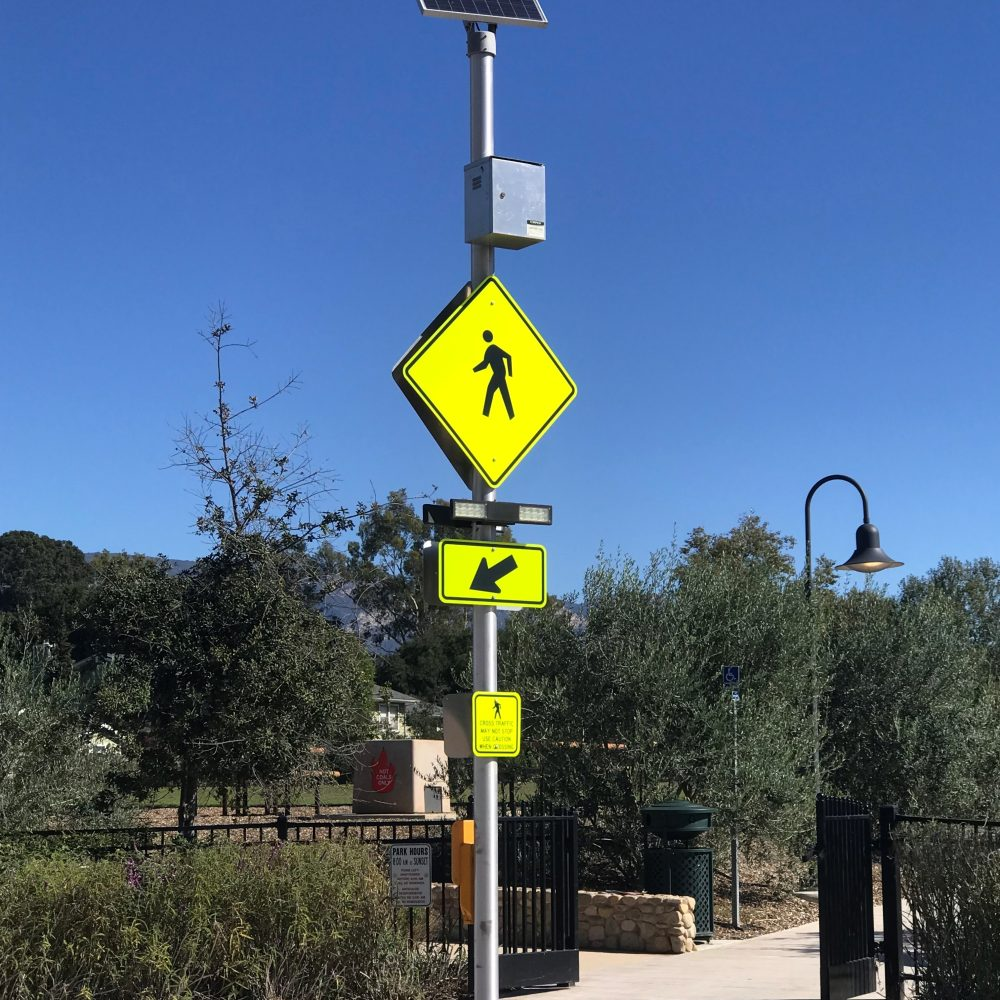

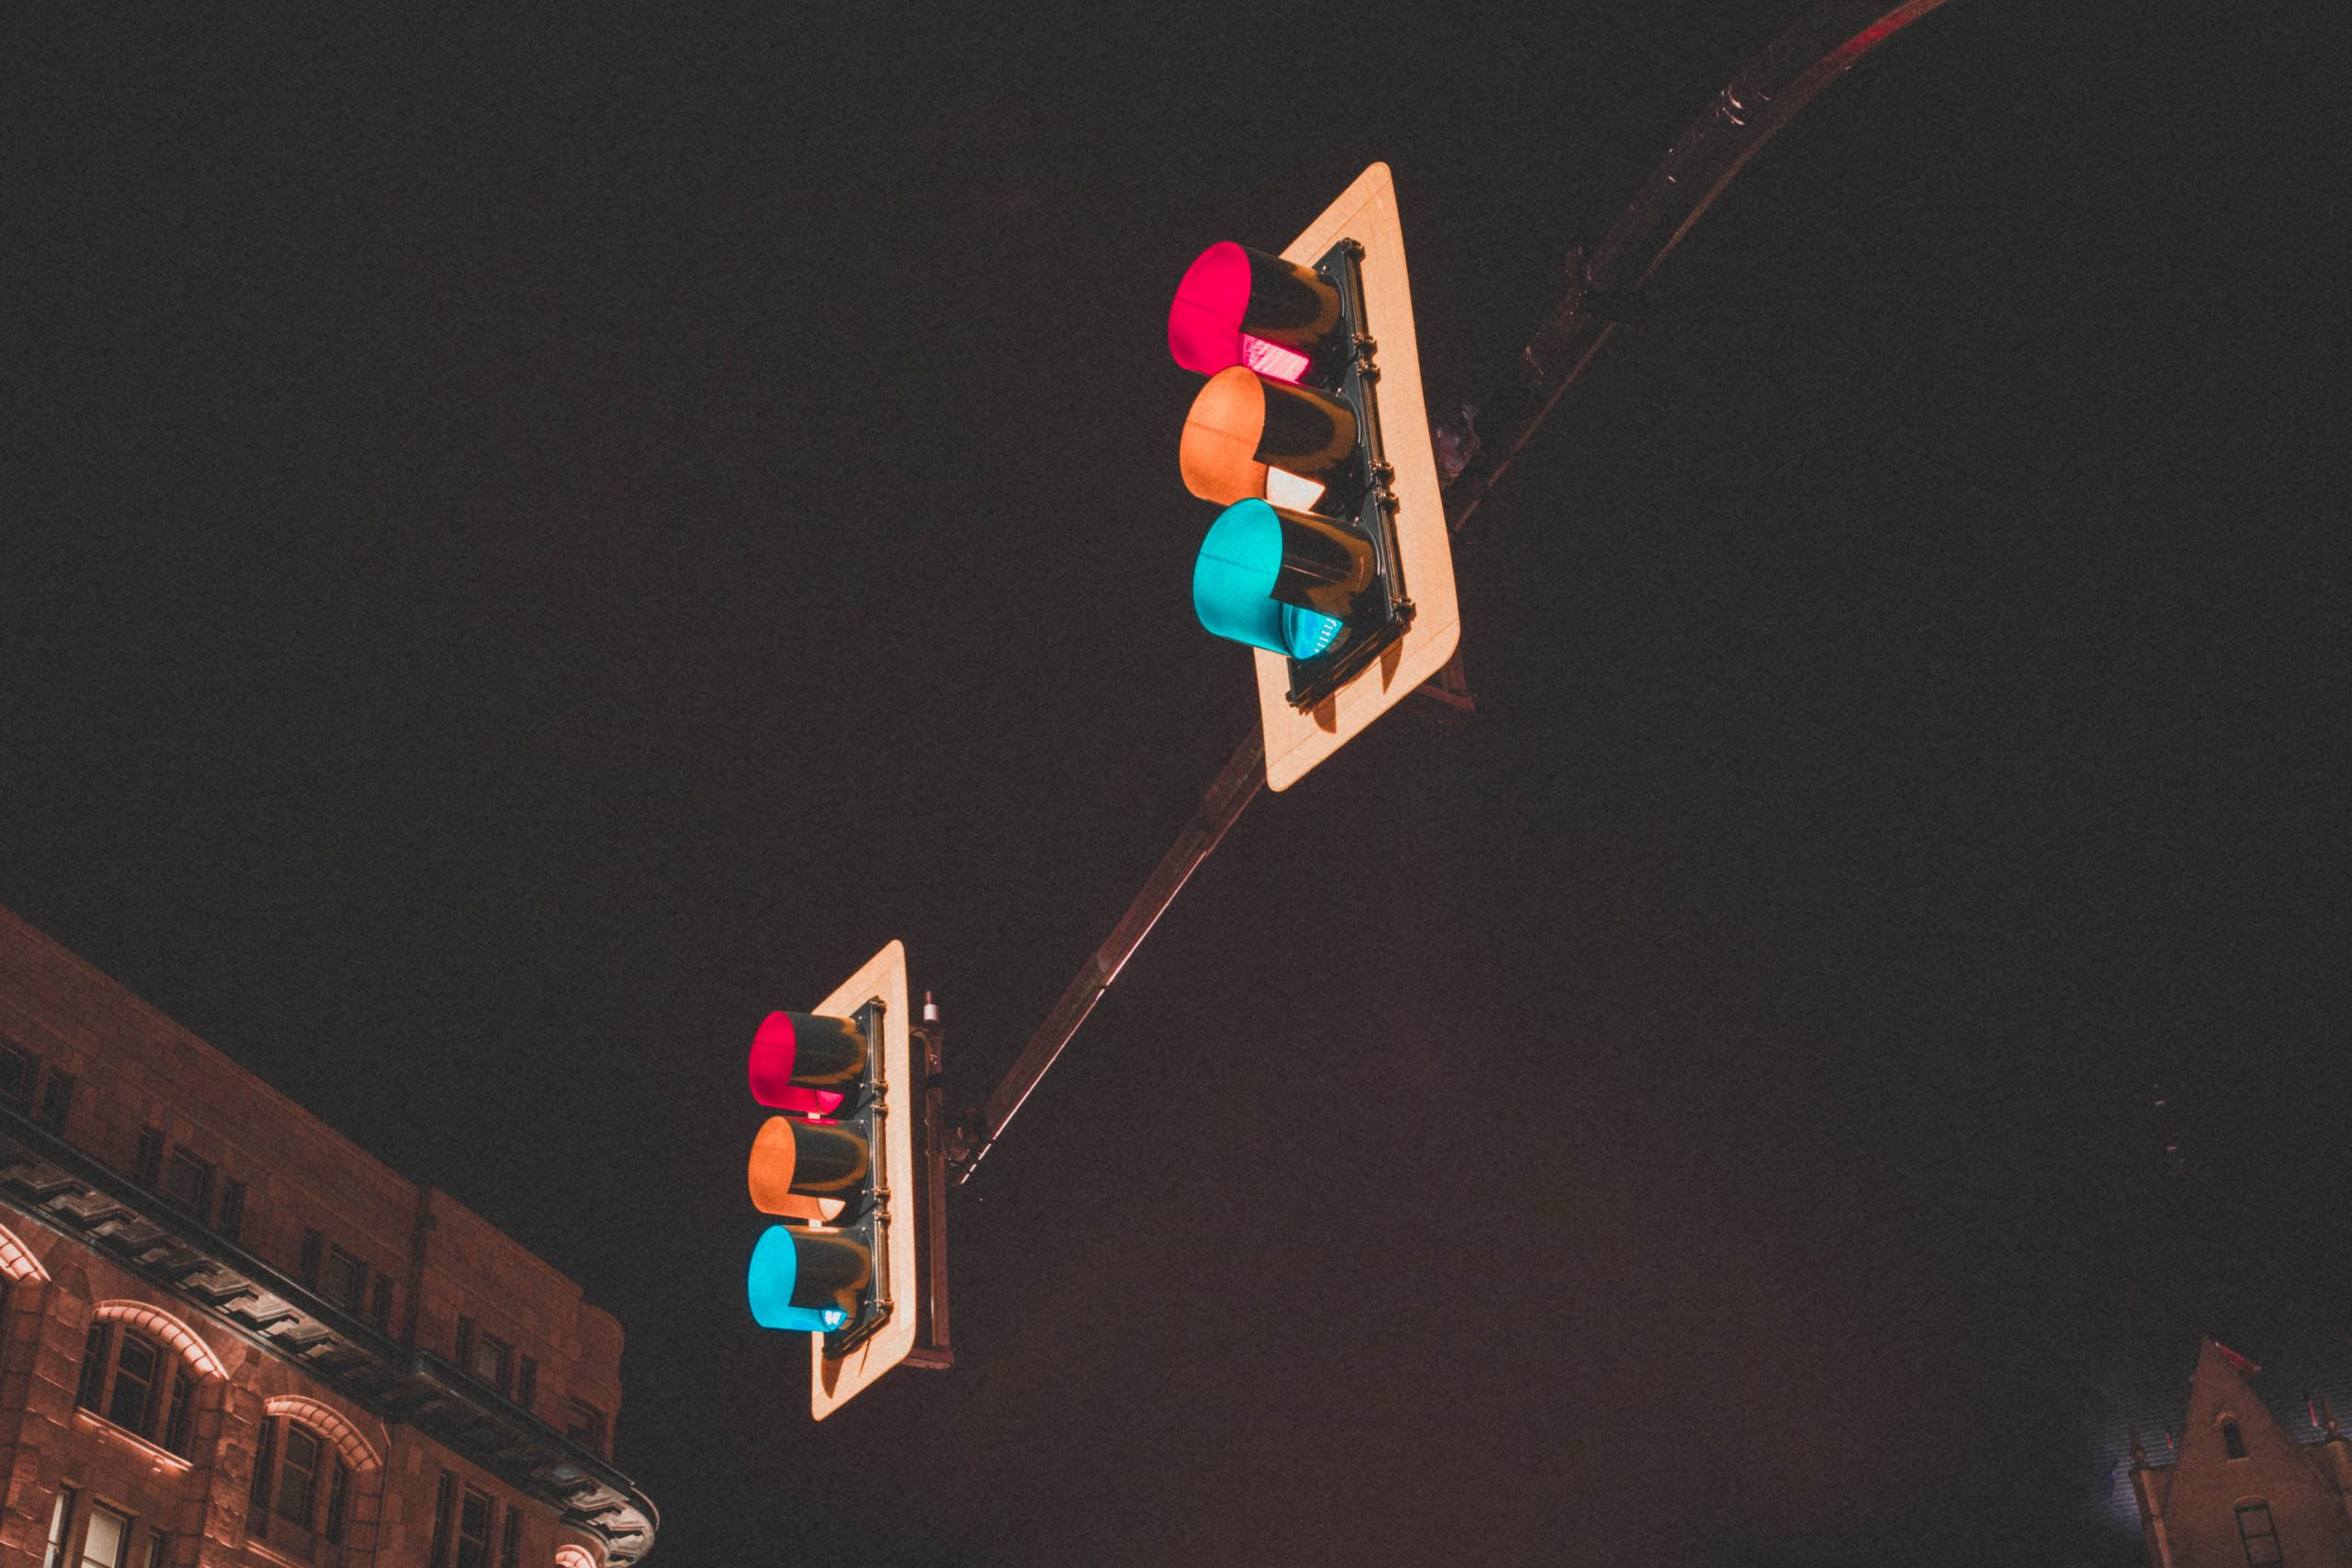

In [17]:
INFER_DIR = "../datasets/road-sign-detection-v2/inference"
images = glob.glob(f"{INFER_DIR}/*.jpg")

for i in range(len(images)):
    display(Image(filename=images[i]))

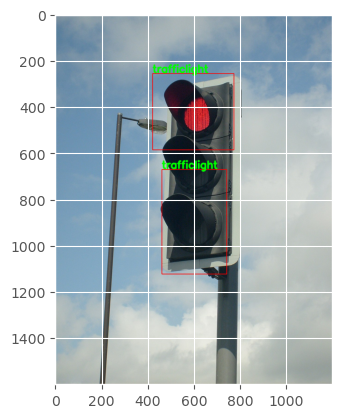

--------------------------------------------------


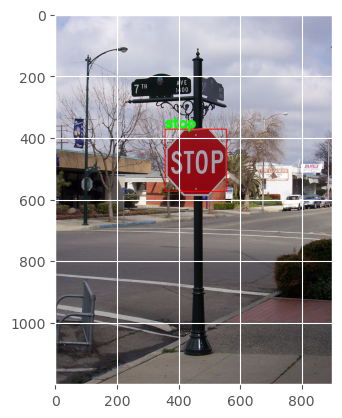

--------------------------------------------------


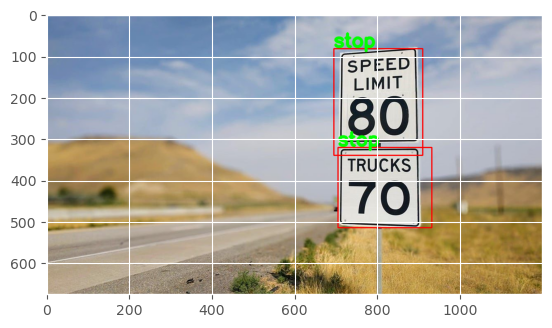

--------------------------------------------------


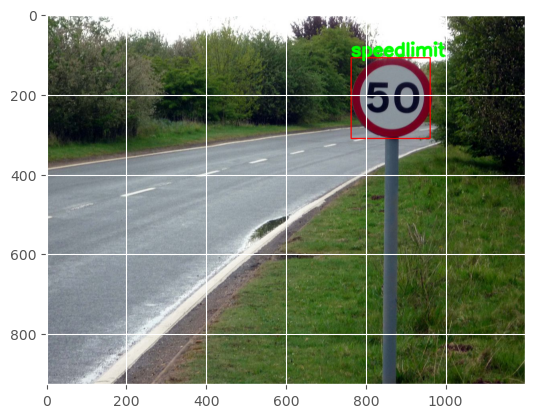

--------------------------------------------------


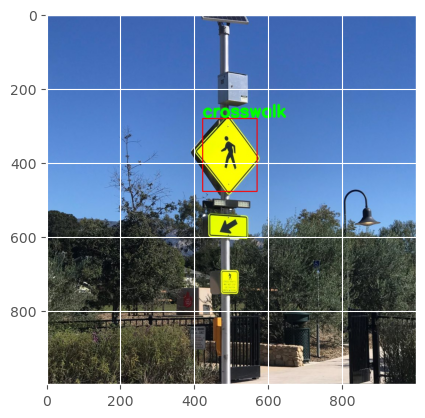

--------------------------------------------------


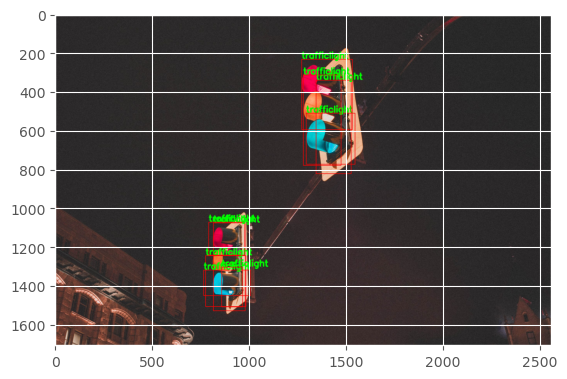

--------------------------------------------------


In [18]:
for i in range(len(images)):
    image = cv2.imread(images[i])
    ori_img = image.copy()
    image = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = np.transpose(image, (2, 0, 1)).astype(float)
    image = torch.tensor(image, dtype=torch.float)
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)

    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].numpy()]

        for j, box in enumerate(draw_boxes):
            cv2.rectangle(ori_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
            cv2.putText(ori_img, pred_classes[j], (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 5, lineType=cv2.LINE_AA)
        
        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_RGB2BGR)
        plt.imshow(ori_img)
        plt.show()
    
    print('-'*50)

The results show that the model tends to detect multiple bounding boxes for a single traffic light. Additionally, the model fails to detect the speed limit sign in the third image. This is likely caused by the dataset for speed limit signs being in a different format (as shown in the fourth image), and there is no data for the particular format of the speed limit sign similar to the third image. On the other hand, the model can detect the crosswalk sign, even though the dataset doesn’t contain examples with that specific yellow background format. From both evaluation metric and inference results, We can see that the inference results align with the evaluation metrics, indicating that the model still needs further improvements.